In [1]:
### few links of LME models in Python
# https://www.kaggle.com/ojwatson/mixed-models - can also work with seaborn, so, nice for quick fits
# tensorflow https://www.tensorflow.org/probability/examples/Linear_Mixed_Effects_Models
# https://github.com/kshedden/Statsmodels-MixedLM
# https://github.com/bambinos/bambi
# https://arviz-devs.github.io/arviz/ - is meant to work with bambi which is based entirely on pymc3 and theano

### temporal analyses and tricks
#https://www.dataquest.io/blog/tutorial-time-series-analysis-with-pandas/
#https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.Series.resample.html
# peak alignment https://ourcodingclub.github.io/tutorials/pandas-time-series/
# https://tslearn.readthedocs.io/en/stable/quickstart.html python toolbox to work with time series

## Inferential stats: Part I


In [2]:
# import modules needed
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import numpy as np
import pandas as pd
import sklearn as sk
import os
import statsmodels.api as sm
import statsmodels.formula.api as smf
import seaborn as sns
from tslearn.metrics import dtw
import warnings
warnings.filterwarnings('ignore')

/home/ondrej/.conda/envs/python3.7/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [3]:
if os.getcwd()=="/data/drive/postdoc/Project4_covid/covid-fear/scripts":
    prefix=""
elif os.getcwd()=="/data/drive/postdoc/Project4_covid/covid-fear/final_overview/content":
    prefix = "../"
# load main dataset
df = pd.read_csv("../../data/full_dataset_only_complete.csv")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5825 entries, 0 to 5824
Columns: 143 entries, PROLIFICID to q8_vaccine_for_everyone_days
dtypes: float64(99), int64(1), object(43)
memory usage: 6.4+ MB


### Relationships within-session 
**What we are interested to predict?**
COVID-related worries, thoughts, avoidance and probability estimates 
- regresssion is somewhat messy, it might be better to explore the data a bit first 
#### Session 1 (tbd)

In [4]:
#sdf = df.loc[df["SESSIONID"]=="1.0",["sr_age","sr_gender", "q6_work_home", "q6_apply_soc_dist", "q6_media_valence",
#                                     "stai_ta", "stai_sa", "sticsa_ta", 
#                                     "sticsa_sa", "bdi", "cat", "obj_severity", "covid_worry", "avoid_beh", 
#                                     "avoid_anx", "avoid_all", "prob_est", "GROUP"]].dropna()
#
#md = smf.mixedlm("covid_worry ~ stai_ta*obj_severity", sdf, groups=sdf["GROUP"])
#mdf = md.fit()
#print(mdf.summary())


## Exploratory plots
### Clustering timecourses
In this anlysis, we group data into 5 clusters using k-Means. For now, the N of clusters is fixed, so 5 are *imposed*, however I will implement a model selection procedure which chooses the most likely amount of clusters. 
The plots are colored according to a secondary variable, in the first case, the color corresponds to trait anxiety. Such analysis should help us understand whether there is any meaningful clustering of participants and whether this maps onto their personality measures. 


In [5]:
from tslearn.utils import to_time_series
from tslearn.clustering import TimeSeriesKMeans, silhouette_score

def estimate_clusters(df, dep_var, metric="dtw"):
    tdf = df[["session", dep_var, "PROLIFICID"]]
    tdf = tdf.pivot(index='PROLIFICID', columns='session', values=dep_var).add_prefix('sess').dropna()
    
    # turn to timeseries data type
    ts = to_time_series(tdf)
   
    # specify model
    model = TimeSeriesKMeans(n_clusters=5, metric=metric, max_iter=20, verbose=0, n_init=5) #specify model
    # fit model 
    model.fit(ts) #fit

    ## not sur ewhat's the silhouette score
    #labels = model.fit_predict(ts) # ??
    #silhouette_score(ts, labels, metric=metric) #?? 

    #which cluster each participant belongs to - awesome!
    cl_ids = model.predict(ts) 

    ## back to pandas
    tdf["cl"] = cl_ids
    tdf["id"] = tdf.index
    
    return tdf, model

def visualize_clusters(df, tdf, model, dep_var, huevar):
    # df - overall data set 
    # tdf - data in wide format, output of estimate_clusters() 
    # model - estimated model
    # dep_var - which variable are we clutering
    # huevar - second variable to color clusters by
    
    # get information from the model
    ts = to_time_series(tdf.drop(columns=["cl", "id"]))
    cl_ids = model.predict(ts) 
    clusters = np.transpose(np.squeeze(model.cluster_centers_))
    (unique, counts) = np.unique(cl_ids, return_counts=True)
    
    # where will labels be shown 
    y = clusters[18,:]
    me=tdf[["sess18", "cl"]].groupby("cl").mean()
    yme=np.array(me["sess18"])
    
    # turn back to long format
    tdf = tdf.melt(id_vars=["id", "cl"], value_vars=["sess"+str(x) for x in range(20)]).set_index("id")
    
    # add anxiety to the dataset
    stdf = tdf.join(df.loc[df["SESSIONID"]=="15.0",[huevar, "PROLIFICID"]].set_index("PROLIFICID").dropna())

    # Set your custom color palette
    pal=sns.color_palette("rocket_r", 10)
    
    #get mean anxiety per bin
    anx_cluster = stdf[["cl", huevar]].groupby(["cl"]).mean()

    # create 10 bins based on min/max anxiety
    anx_bins = np.linspace(anx_cluster[huevar].min(), anx_cluster[huevar].max(), 10)

    # get index of which anxity bin does each cluster belong to 
    anx_idx = np.digitize(anx_cluster[huevar],anx_bins)

    newpal = [pal[ival-1] for idx, ival in enumerate(anx_idx)]
    
    plt.figure(figsize=(10,7))
    ax = sns.lineplot(data=tdf, x="session", y="value", hue="cl", palette=newpal, legend=False)
    ax.set_xticklabels([str(i) for i in range(20)])
    plt.ylabel(dep_var)
    x = 18
    for i,v,c,a,y in zip(np.array(anx_cluster.index), unique, counts, anx_cluster[huevar], yme):
        ax.annotate("n="+str(c)+" "+huevar+"="+str(np.round(a)), (x,y),
                   bbox=dict(boxstyle="round", fc="w", edgecolor=newpal[i]))
    
    plt.show()



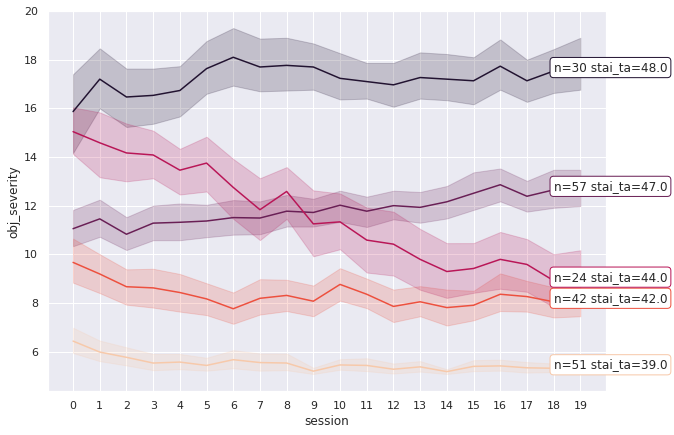

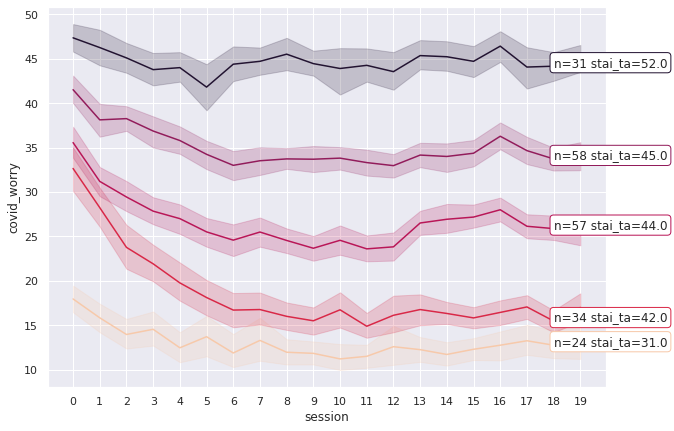

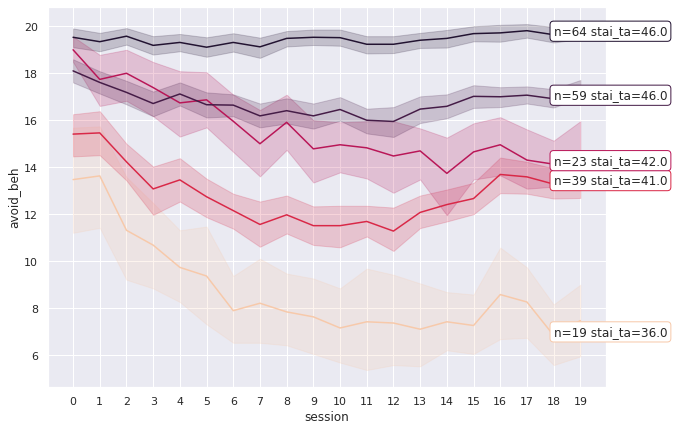

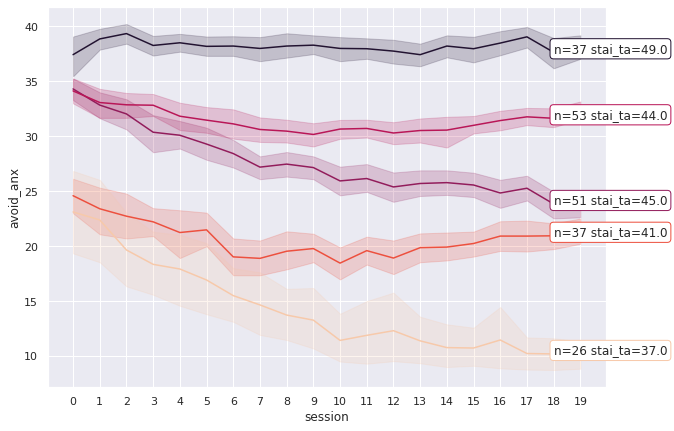

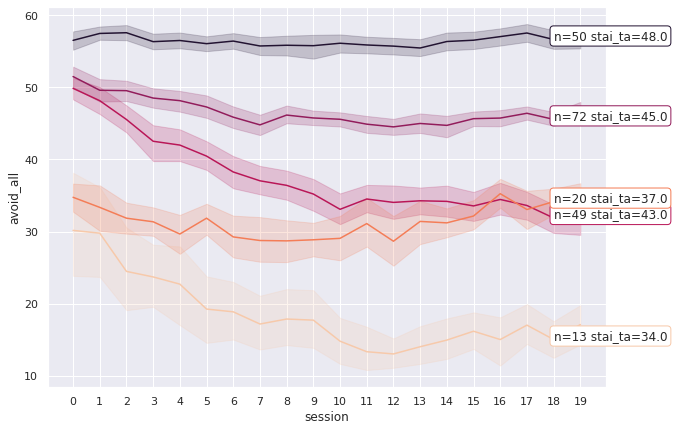

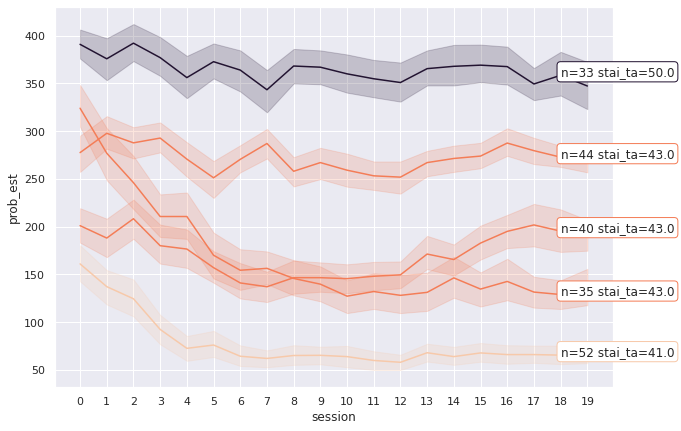

In [6]:
var = ["obj_severity", "covid_worry", "avoid_beh", "avoid_anx", "avoid_all", "prob_est"]
# qs not included because they start later in the project: "covid_thoughts", "skepticism"
for dep_var in var:
    tdf, model = estimate_clusters(df, dep_var)
    visualize_clusters(df, tdf, model, dep_var, "stai_ta")               